In [2]:
# data manipulation
import pandas as pd
import numpy as np
import re

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from ggplot import *

# machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

In [3]:
def get_regex(pattern, string):
    m = re.search(pattern, string)
    if m:
        return m.group(0)
    return None

In [4]:
train = pd.read_csv('train.csv')

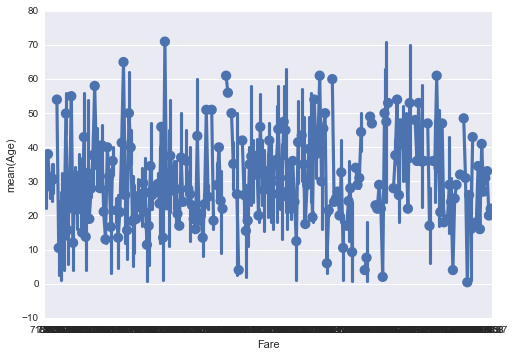

In [19]:
sns.pointplot(data=train, x='Fare', y='Age')

#### Missing Values (Age)

In [5]:

train['AgeFill'] = train[['Pclass', 'Sex', 'Age']].apply(get_age, axis=1)
_, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 4), sharey=True)
axis1.set_title('Age Distribution')
axis2.set_title('Missing Age Filled')
sns.countplot('Age', data=train, ax=axis1)
sns.countplot('AgeFill', data=train, ax=axis2)

NameError: name 'get_age' is not defined

In [6]:
class_sex_age = train.groupby(['Pclass', 'Sex'])['Age'].mean()
def get_age(row):
    pclass, sex, age = row
    if pd.isnull(age):
        return class_sex_age[pclass][sex]
    return age


class_sex_fare = train.groupby(['Pclass', 'Sex'])['Fare'].mean()
def get_fare(row):
    pclass, sex, fare = row
    if pd.isnull(fare):
        return class_sex_fare[pclass][sex]
    return fare

def preprocess_df(df):
    """Prepares dataset for prediction"""
    
    # fill missing values
    df['AgeFill'] = df[['Pclass', 'Sex', 'Age']].apply(get_age, axis=1)
    df['AgeIsNull'] = df['Age'].isnull().astype(int)
    df['SexFill'] = df['Sex']
    df['FareFill'] = df[['Pclass', 'SexFill', 'Fare', 'AgeFill']].apply(get_fare, axis=1)
    
    # categorical vars
    dummies_test_sex = pd.get_dummies(df['SexFill'])
    
    # remove unnecessary columns
    df = df[['Pclass', 'FareFill', 'AgeFill', 'AgeIsNull']].join(dummies_test_sex)
    
    return df
# fit
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train.ix[:, 1:], train['Survived'],
                                                                     test_size=0.1, random_state=42)
X_train = preprocess_df(X_train)
# X_train = preprocess_df(train.ix[:, 1:])
# y_train = train['Survived']
model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)
# validate
X_test = preprocess_df(X_test)
model.score(X_test, y_test)

ValueError: ('too many values to unpack', u'occurred at index 165')

In [321]:
sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1], reverse=True)

[('male', 0.44072044205972338),
 ('FareFill', 0.41740893990965078),
 ('Pclass', 0.14187061803062573),
 ('female', 0.0)]

#### Predict

In [322]:
test = pd.read_csv('test.csv')
test_data = preprocess_df(test)
predictions = model.predict(test_data)
test['Survived'] = predictions
test[['PassengerId', 'Survived']].to_csv('predictions.csv', index=False)